This Notebook article teaches you how to write a custom training loop in pure PyTorch, create a custom torch `Dataset` class, compute metrics for model performance, and scale the training on any hardware like GPU, TPU, IPU, or distributed training with [LightningLite](https://devblog.pytorchlightning.ai/scale-your-pytorch-code-with-lightninglite-d5692a303f00).

Check out the original [Kaggle Notebook here.](https://www.kaggle.com/code/aniketmaurya/happywhale-pytorch-training-from-scratch-lite)

![Photo by Pixabay from Pexels](https://images.pexels.com/photos/417196/pexels-photo-417196.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2)

## 🕵 Explore the provided data

> EDA is taken from [Notebook](https://www.kaggle.com/code/jirkaborovec/whale-dolphin-eda-classify-lit-flash?scriptVersionId=89274025) of Jirka

In [1]:
!ls -l /kaggle/input/happy-whale-and-dolphin

PATH_DATASET = "/kaggle/input/happy-whale-and-dolphin"

total 4668
-rw-r--r-- 1 nobody nogroup 2404234 Feb  1 16:45 sample_submission.csv
drwxr-xr-x 2 nobody nogroup       0 Feb  1 16:47 test_images
-rw-r--r-- 1 nobody nogroup 2371769 Feb  1 16:47 train.csv
drwxr-xr-x 2 nobody nogroup       0 Feb  1 16:51 train_images


### Browsing the metadata

In [2]:
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sn.set()

df_train = pd.read_csv(os.path.join(PATH_DATASET, "train.csv"))
display(df_train.head())
print(f"Dataset size: {len(df_train)}")
print(f"Unique ids: {len(df_train['individual_id'].unique())}")

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


Dataset size: 51033
Unique ids: 15587


Lets see how many speaced we have in the database...

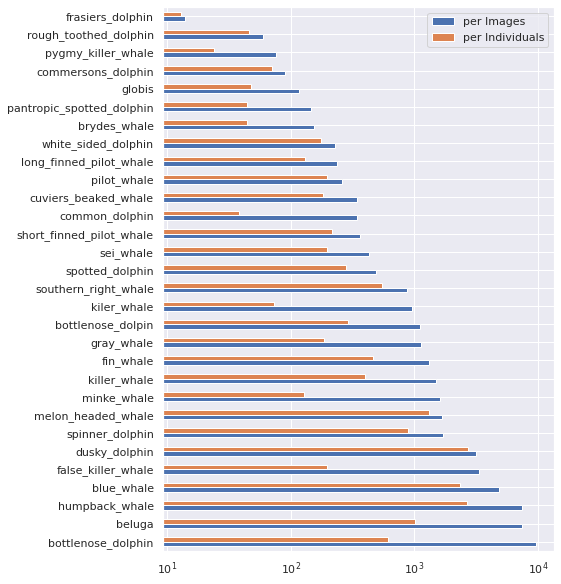

In [3]:
counts_imgs = df_train["species"].value_counts()
counts_inds = df_train.drop_duplicates("individual_id")["species"].value_counts()

ax = pd.concat(
    {"per Images": counts_imgs, "per Individuals": counts_inds}, axis=1
).plot.barh(grid=True, figsize=(7, 10))
ax.set_xscale("log")

And compare they with unique individuals... 

**Note:** that the counts are in log scale

In [4]:
import numpy as np
from pprint import pprint

species_individuals = {}
for name, dfg in df_train.groupby("species"):
    species_individuals[name] = dfg["individual_id"].value_counts()

si_max = max(list(map(len, species_individuals.values())))
si = {n: [0] * si_max for n in species_individuals}
for n, counts in species_individuals.items():
    si[n][: len(counts)] = list(np.log(counts))
si = pd.DataFrame(si)

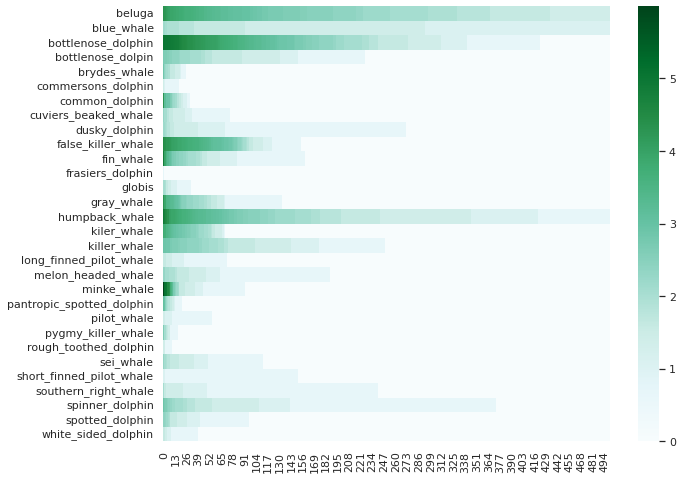

In [5]:
import seaborn as sn

fig = plt.figure(figsize=(10, 8))
ax = sn.heatmap(si[:500].T, cmap="BuGn", ax=fig.gca())

And see the top individulas

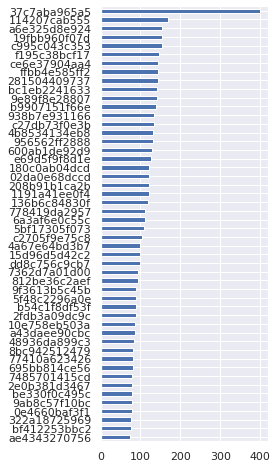

In [6]:
ax = (
    df_train["individual_id"]
    .value_counts(ascending=True)[-50:]
    .plot.barh(figsize=(3, 8), grid=True)
)  # ascending=True

## Browse some images

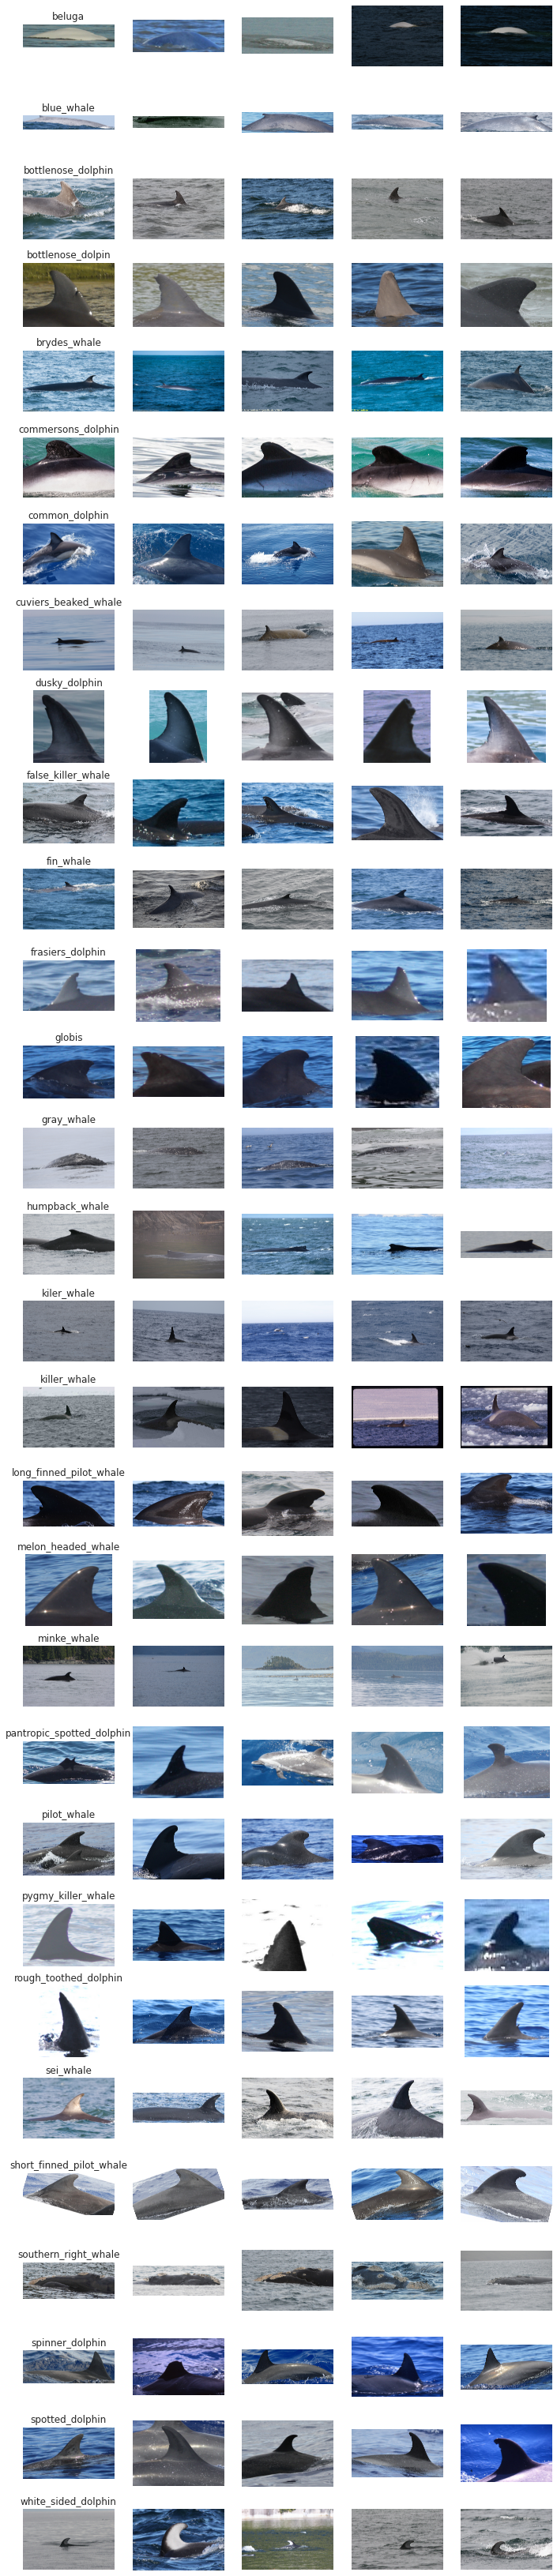

In [7]:
nb_species = len(df_train["species"].unique())
fig, axarr = plt.subplots(ncols=5, nrows=nb_species, figsize=(12, nb_species * 2))

for i, (name, dfg) in enumerate(df_train.groupby("species")):
    axarr[i, 0].set_title(name)
    for j, (_, row) in enumerate(dfg[:5].iterrows()):
        im_path = os.path.join(PATH_DATASET, "train_images", row["image"])
        img = plt.imread(im_path)
        axarr[i, j].imshow(img)
        axarr[i, j].set_axis_off()

In [ ]:
# !pip install -q -U timm pytorch-lightning>=1.6

In [9]:
import torch

import timm
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split


from torchmetrics import F1
import torch.nn.functional as F

from tqdm.auto import tqdm

import torch
from torch.optim.lr_scheduler import StepLR

## Create DataLoader 🗄️

`DataLoader` is an iterable object which contains your input image data and the target label. To create a DataLoader, we first need to implement a torch `Dataset` class. We define `MyDataset` class which inherits from `Dataset` and it will implement `__len__` and `__getitem__` method.

In [10]:
label_to_idx = {e: i for i, e in enumerate(df_train.species.unique())}


class MyDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df
        self.root = os.path.join(PATH_DATASET, "train_images")
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        data = self.df.iloc[idx]
        image = Image.open(self.root + f"/{data.image}").convert("RGB")
        label = label_to_idx[data.species]
        if self.transforms:
            image = self.transforms(image)
        return image, label


def random_split_dataset(data: Dataset, pct=0.9):
    """
    Randomly splits dataset into two sets. Length of first split is len(data) * pct.
    Source: https://github.com/gradsflow/gradsflow/blob/main/gradsflow/data/common.py#L20
    Args:
        data: pytorch Dataset object with `__len__` implementation.
        pct: percentage of split.
    """
    n = len(data)
    split_1 = int(n * pct)
    split_2 = n - split_1
    return random_split(data, (split_1, split_2))

We define image augmentation to make our classifier robust. We will use the function `random_split_dataset` to split dataset into train and validation set.
Once we have our Dataset object, we can create a DataLoader class like this - `dataloader = DataLoader(dataset, batch_size=8)`

In [11]:
transforms = T.Compose([T.AutoAugment(), T.Resize((224, 224)), T.ToTensor()])


ds = MyDataset(df_train, transforms)
split_pct = 0.9

train_ds, val_ds = random_split_dataset(ds, 0.9)

## Write Training Loop 🛠️

Now, we have our dataloader ready we can create our classifier and write training loop.
A training loop consists of model prediction, loss computation, backward propagation and model weight update by the optimizer.


We will start with a basic training loop then will use `LightningLite` to enable multiple hardware, precision and distributed training.

First we will create model, optimizer, loss function and metrics.

In [12]:
batch_size = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
dry_run = True
num_epochs = 5


model = timm.create_model(
    "efficientnet_b0", pretrained=True, num_classes=len(label_to_idx)
)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
criterion = torch.nn.CrossEntropyLoss()
metric = F1().to(device)

train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


### Training Loop

For writing the training loop we will iterate a `for loop` for given number of epochs `num_epochs`. Set the model to training mode with `model.train()` and iterate through the dataloader. We pass the data to model and calculate the crossentropy loss. We do `loss.backward()` to compute gradients followed by `optimizer.step()` which will update the model weights.

For model evaluation we define a validation loop which will calculate the `F1 accuracy` on the validation dataset. For validation we set our model to eval mode with `model.eval()` method. For calculating F1 accuracy, we use [TorchMetrics](https://torchmetrics.readthedocs.io/) which contains a collection of Machine Learning metrics for distributed, scalable PyTorch models and an easy-to-use API to create custom metrics.

In [13]:
# EPOCH LOOP
for epoch in tqdm(range(1, num_epochs + 1)):

    # TRAINING LOOP
    model.train()
    for batch_idx, (data, target) in tqdm(
        enumerate(train_loader), total=len(train_ds) // batch_size
    ):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx == 0) or ((batch_idx + 1) % log_interval == 0):
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if dry_run:
                break

    # TESTING LOOP
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            # WITH TorchMetrics
            metric(output, target)

            if dry_run:
                break

    # all_gather is used to aggregated the value across processes
    test_loss = test_loss / len(val_loader.dataset)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: ({metric.compute():.0f}%)\n"
    )
    metric.reset()

    if dry_run:
        break

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11482 [00:00<?, ?it/s]

Train Epoch: 1 [0/45929 (0%)]	Loss: 3.646841

Test set: Average loss: 0.0008, Accuracy: (0%)



## 👷 Scale Model Training 

Our dry run was successful 🎉!
Now, let's scale our training on a hardware accelerator like GPU or TPU. We can also use distributed training if multiple devices are available. For this purpose we use `LightningLite`, it scales PyTorch model training loop with minimal changes. That means we will retain the full control of our training loop! It also enables Precision support abd DDP training.

To use LightningLite, we will import it from PyTorch Lightning library. We implement LightningLite and override `run` method. We can just copy paste our whole training loop code inside the `run` method and then just make these three changes to our code.

1. `model, optimizer = self.setup(model, optimizer)`
2. `dataloader = self.setup_dataloaders(dataloader)`
3. Replace `loss.backward()` with `self.backward(loss)`


![GIF](https://pl-public-data.s3.amazonaws.com/docs/static/images/lite/lightning_lite.gif)

In [14]:
from pytorch_lightning.lite import LightningLite


class CustomTrainer(LightningLite):
    def run(
        self,
        num_epochs,
        batch_size,
        gamma=0.7,
        dry_run: bool = False,
        save_model=True,
        log_interval=10,
    ):
        model = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=len(label_to_idx)
        )
        optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        metric = F1().to(self.device)
        print(self.device)

        # don't forget to call `setup` to prepare for model / optimizer for distributed training.
        # the model is moved automatically to the right device.
        model, optimizer = self.setup(model, optimizer)

        pin_memory = "cuda" in self.device.type
        train_loader, val_loader = self.setup_dataloaders(
            DataLoader(train_ds, batch_size=batch_size, pin_memory=pin_memory),
            DataLoader(val_ds, batch_size=batch_size, pin_memory=pin_memory),
        )

        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

        # EPOCH LOOP
        for epoch in tqdm(range(1, num_epochs + 1)):

            # TRAINING LOOP
            model.train()
            for batch_idx, (data, target) in tqdm(
                enumerate(train_loader), total=len(train_ds) // batch_size
            ):
                # NOTE: no need to call `.to(device)` on the data, target
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                self.backward(loss)  # instead of loss.backward()

                optimizer.step()
                if (batch_idx == 0) or ((batch_idx + 1) % log_interval == 0):
                    print(
                        "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                            epoch,
                            batch_idx * len(data),
                            len(train_loader.dataset),
                            100.0 * batch_idx / len(train_loader),
                            loss.item(),
                        )
                    )
                    if dry_run:
                        break

            scheduler.step()

            # TESTING LOOP
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    # NOTE: no need to call `.to(device)` on the data, target
                    output = model(data)
                    test_loss += criterion(output, target).item()

                    # WITH TorchMetrics
                    metric(output, target)

                    if dry_run:
                        break

            # all_gather is used to aggregated the value across processes
            test_loss = self.all_gather(test_loss).sum() / len(val_loader.dataset)

            print(
                f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: ({metric.compute():.0f}%)\n"
            )
            metric.reset()

            if dry_run:
                break

        # When using distributed training, use `self.save`
        # to ensure the current process is allowed to save a checkpoint
        if save_model:
            self.save(model.state_dict(), "model.pt")

That's all we need to do. Now we can select any supported hardware, precision type, number of devices, or [training strategy](https://pytorch-lightning.readthedocs.io/en/latest/starter/lightning_lite.html#strategy).

Run this cell to train the model on one GPU.

In [15]:
trainer = CustomTrainer(accelerator="gpu", gpus=1)
trainer.run(num_epochs=1, batch_size=128)

cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

Train Epoch: 1 [0/45929 (0%)]	Loss: 4.033646
Train Epoch: 1 [1152/45929 (3%)]	Loss: 2.897996
Train Epoch: 1 [2432/45929 (5%)]	Loss: 2.228965
Train Epoch: 1 [3712/45929 (8%)]	Loss: 1.733439
Train Epoch: 1 [4992/45929 (11%)]	Loss: 1.733582
Train Epoch: 1 [6272/45929 (14%)]	Loss: 1.438736
Train Epoch: 1 [7552/45929 (16%)]	Loss: 1.324237
Train Epoch: 1 [8832/45929 (19%)]	Loss: 1.311875
Train Epoch: 1 [10112/45929 (22%)]	Loss: 1.153679
Train Epoch: 1 [11392/45929 (25%)]	Loss: 1.068135
Train Epoch: 1 [12672/45929 (28%)]	Loss: 0.795189
Train Epoch: 1 [13952/45929 (30%)]	Loss: 0.806610
Train Epoch: 1 [15232/45929 (33%)]	Loss: 0.847775
Train Epoch: 1 [16512/45929 (36%)]	Loss: 0.828618
Train Epoch: 1 [17792/45929 (39%)]	Loss: 0.805902
Train Epoch: 1 [19072/45929 (42%)]	Loss: 0.794924
Train Epoch: 1 [20352/45929 (44%)]	Loss: 0.730848
Train Epoch: 1 [21632/45929 (47%)]	Loss: 0.791776
Train Epoch: 1 [22912/45929 (50%)]	Loss: 0.567644
Train Epoch: 1 [24192/45929 (53%)]	Loss: 0.712434
Train Epoch: 1 

## Happy Training! ⚡️🎉